# Modelisation de la consommation totale d'energie

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.preprocessing as sk_prepro
from sklearn import metrics

In [2]:
df = pd.read_csv('data_full.csv')

In [3]:
data_num = df
target_tag = 'SiteEnergyUse(kBtu)'
target = data_num[target_tag]
data_num = data_num.drop(labels = [target_tag, 'TotalGHGEmissions', 'ENERGYSTARScore','SiteEUI(kBtu/sf)'], axis = 1)

In [4]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634 entries, 0 to 1633
Columns: 573 entries, 0 to ThirdLargestPropertyUseTypeGFA
dtypes: float64(573)
memory usage: 7.1 MB


## Modèle linéaire

In [5]:
from sklearn.linear_model import Ridge
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor

In [25]:
#first let's test this on knregressoe
xtrain, xtest, ytrain, ytest = train_test_split(data_num, target, test_size = 0.2)

#let's standard scale

sscaler = sk_prepro.StandardScaler()
sscaler_fit = sscaler.fit(xtrain)
xtrain = sscaler_fit.transform(xtrain)
xtest = sscaler_fit.transform(xtest)
#log scale the target
ytrain = np.log(ytrain)
ytest = np.log(ytest)


In [7]:
from sklearn import linear_model
line_reg = linear_model.LinearRegression()

In [34]:
def true_pred_plot(y_train,pred_train, y_test, pred_test):
    fig, ax = plt.subplots(2, figsize = (10,10))
    
    line_reg_train = line_reg.fit(np.array(pred_train).reshape(-1,1),y_train)
    r2_train = line_reg_train.score(np.array(pred_train).reshape(-1,1),y_train)
    rmse_train = (np.sqrt(metrics.mean_squared_error(y_train, pred_train))/np.mean(ytrain))
    a = float(line_reg_train.coef_)
    b= line_reg_train.intercept_
    ax[0].scatter( y_train, pred_train)
    ax[0].plot([a*np.abs(b)+b, a*y_train.max()+b],[np.abs(b), ytrain.max()], linestyle = 'dashed')
    ax[0].text(0.7,0.4,'R2 : {:.3f} NRMSE : {: .2f}'.format(r2_train,rmse_train), transform = ax[0].transAxes)
    ax[0].set_xlabel('True values')
    ax[0].set_ylabel('Predicted values')
    ax[0].set_xlim(y_train.min(),y_train.max())
    ax[0].set_ylim(pred_train.min(),pred_train.max())
    ax[0].set_title('On train values')

    line_reg_test  = line_reg.fit(np.array(pred_test).reshape(-1,1),y_test)
    r2_test =  line_reg_test.score(np.array(pred_test).reshape(-1,1),y_test)
    rmse_test = (np.sqrt(metrics.mean_squared_error(y_test, pred_test))/np.mean(ytest))
    a = float(line_reg_test.coef_)
    b=  line_reg_test.intercept_
    ax[1].scatter( y_test, pred_test)
    ax[1].plot([a*np.abs(b)+b, a*y_test.max()+b],[np.abs(b), y_test.max()], linestyle = 'dashed')
    ax[1].text(0.7,0.4,'R2 : {:.3f} NRMSE : {: .2f}'.format(r2_test, rmse_test), transform = ax[1].transAxes)
    ax[1].set_xlabel('True values')
    ax[1].set_ylabel('Predicted values')
    ax[1].set_xlim(y_test.min(),y_test.max())
    ax[1].set_ylim(pred_test.min(),pred_test.max())
    ax[1].set_title('On test values')
    
    plt.show()
    plt.clf()

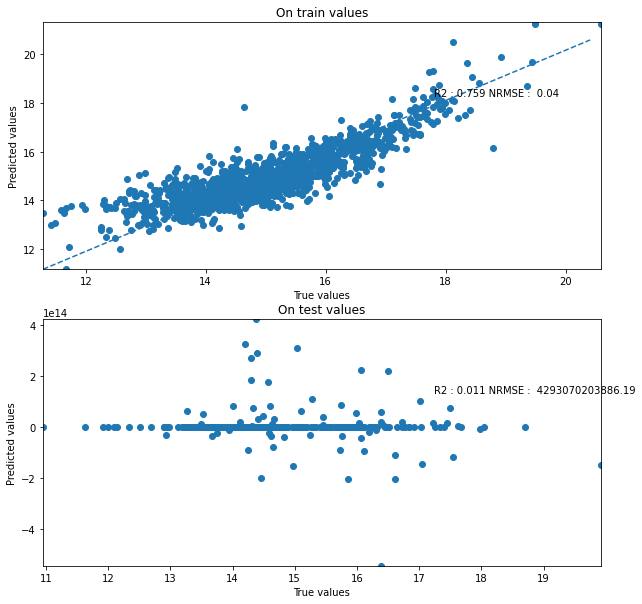

<Figure size 432x288 with 0 Axes>

In [32]:
line_reg_m = linear_model.LinearRegression()

line_reg_m.fit(xtrain,ytrain)


true_pred_plot(ytrain, line_reg_m.predict(xtrain), ytest, line_reg_m.predict(xtest))

In [26]:
#let's grid search for the k

k_grid = {'n_neighbors' : list(range(2,16))}
score = 'r2'

reg = GridSearchCV(KNeighborsRegressor(), k_grid, cv =3, scoring = score, verbose = 1)

reg.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(reg.best_params_))

print('GridCV results : ')
for mean, std, k in zip(reg.cv_results_['mean_test_score'],
                       reg.cv_results_['std_test_score'],
                       reg.cv_results_['params']):
    print('{} = {:.3f} (+/- {:.3f}) for {}'.format(score,mean,std*2,k))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best params on training set : {'n_neighbors': 6}
GridCV results : 
r2 = 0.360 (+/- 0.050) for {'n_neighbors': 2}
r2 = 0.400 (+/- 0.041) for {'n_neighbors': 3}
r2 = 0.420 (+/- 0.039) for {'n_neighbors': 4}
r2 = 0.424 (+/- 0.039) for {'n_neighbors': 5}
r2 = 0.429 (+/- 0.022) for {'n_neighbors': 6}
r2 = 0.419 (+/- 0.008) for {'n_neighbors': 7}
r2 = 0.424 (+/- 0.012) for {'n_neighbors': 8}
r2 = 0.427 (+/- 0.021) for {'n_neighbors': 9}
r2 = 0.418 (+/- 0.016) for {'n_neighbors': 10}
r2 = 0.417 (+/- 0.019) for {'n_neighbors': 11}
r2 = 0.418 (+/- 0.017) for {'n_neighbors': 12}
r2 = 0.417 (+/- 0.019) for {'n_neighbors': 13}
r2 = 0.417 (+/- 0.014) for {'n_neighbors': 14}
r2 = 0.414 (+/- 0.015) for {'n_neighbors': 15}


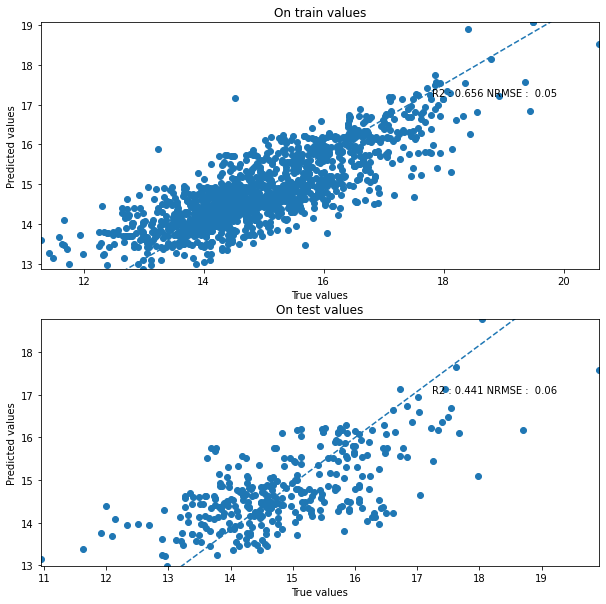

<Figure size 432x288 with 0 Axes>

In [31]:
model = KNeighborsRegressor(n_neighbors=6).fit(xtrain, ytrain)

true_pred_plot(ytrain, model.predict(xtrain), ytest, model.predict(xtest))

In [33]:
#let's try with a svr
C_range = [1.0, 5.0, 10.0, 100.0]
kernels = ['linear', 'rbf', 'sigmoid', 'poly']
degrees = [2,3,4]
gamma_range  = np.logspace(-2, 1, 10)
#gamma_range = np.logspace(-2, 1, 10)
#'gamma' : gamma_range
param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees}

score = 'neg_mean_squared_error'

svr_cv = GridSearchCV(svm.SVR(), param_grid, cv = 3, scoring = score, verbose = 1)

svr_cv.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(svr_cv.best_params_))

Fitting 3 folds for each of 120 candidates, totalling 360 fits
Best params on training set : {'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}


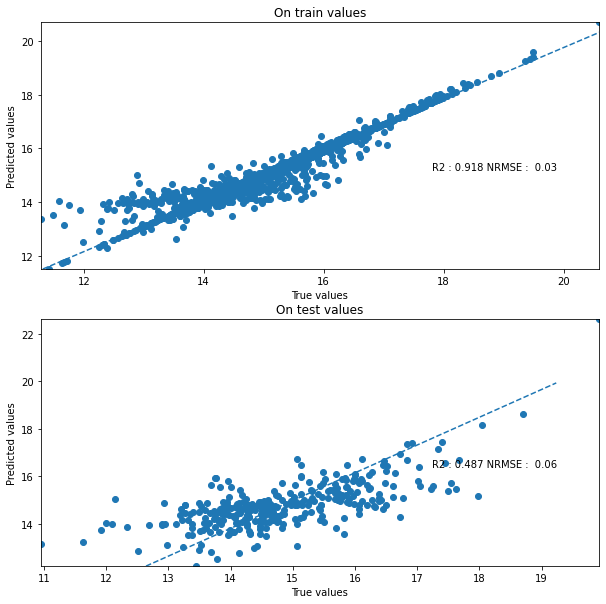

<Figure size 432x288 with 0 Axes>

In [35]:
svr = svm.SVR(kernel="poly", C=10.0, gamma = 0.01, degree = 3)
svr = svr.fit(xtrain,ytrain)

true_pred_plot(ytrain, svr.predict(xtrain), ytest, svr.predict(xtest))

In [36]:
from sklearn import kernel_ridge
#let's try with a ridge regression


alpha_range = [1.0, 5.0, 10.0, 100.0]
kernels = ['linear', 'poly', 'sigmoid', 'rbf']
degrees = [3,4,5]
gamma_range  = np.logspace(-2, 1, 10)


param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees, 'alpha' : alpha_range}

score = 'neg_mean_absolute_percentage_error'

kernel_ridge_cv = GridSearchCV(kernel_ridge.KernelRidge(), param_grid, cv = 3, scoring = score, verbose = 1)

kernel_ridge_cv.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(kernel_ridge_cv.best_params_))

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_mo

Best params on training set : {'alpha': 5.0, 'degree': 3, 'gamma': 0.021544346900318832, 'kernel': 'sigmoid'}


E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


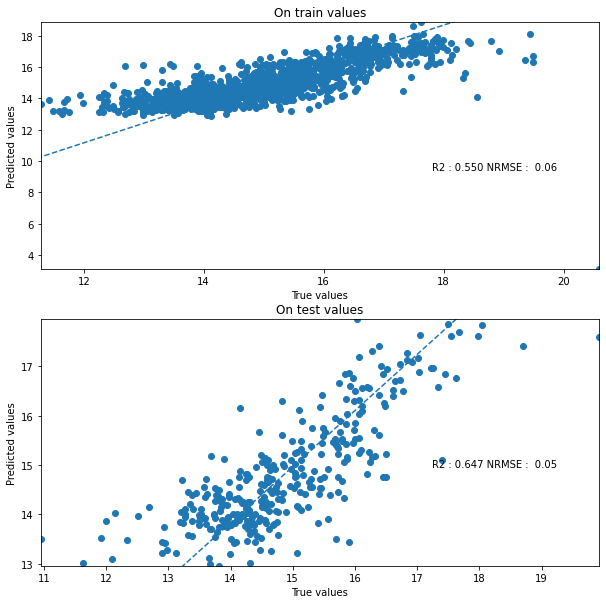

<Figure size 432x288 with 0 Axes>

In [37]:
model = kernel_ridge.KernelRidge(alpha = 5.0, kernel = 'sigmoid', degree = 3, gamma = 0.02)
model = model.fit(xtrain, ytrain)

true_pred_plot(ytrain, model.predict(xtrain), ytest, model.predict(xtest))

## Neural network

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [46]:
#test with a single perceptron
model1 = keras.Sequential()
model1.add(keras.Input(shape = xtrain.shape[1]))
model1.add(layers.Dense(1,input_dim = 2, activation = 'linear'))

model1.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model1.summary()

history1 = model1.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 574       
                                                                 
Total params: 574
Trainable params: 574
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1307/1307 [==============================] - 1s 903us/step - loss: 107.5211 - root_mean_squared_error: 21.4125
Epoch 2/50
1307/1307 [==============================] - 1s 897us/step - loss: 86.9964 - root_mean_squared_error: 19.6033
Epoch 3/50
1307/1307 [==============================] - 1s 888us/step - loss: 78.0315 - root_mean_squared_error: 19.0986
Epoch 4/50
1307/1307 [==============================] - 1s 906us/step - loss: 69.6064 - root_mean_squared_error: 18.5509
Epoch 5/50
1307/1307 [==============================] - 1s 864us/step - loss: 62.3961 - root_mean_s

11/11 [==============================] - 0s 903us/step


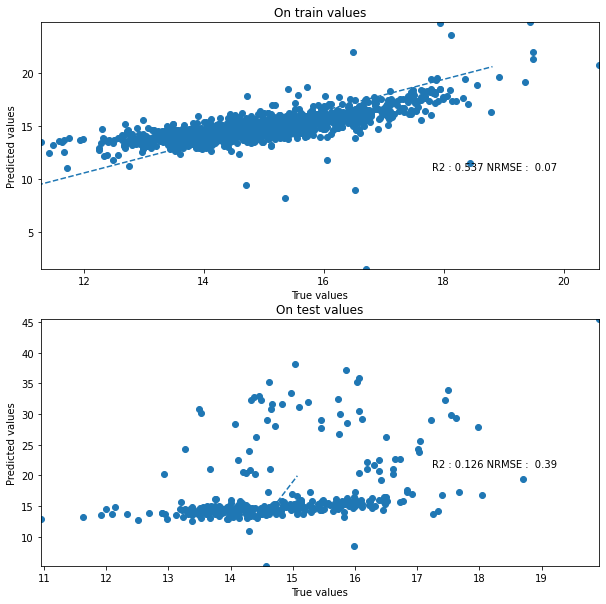

<Figure size 432x288 with 0 Axes>

In [47]:
true_pred_plot(ytrain, model1.predict(xtrain), ytest, model1.predict(xtest))

In [43]:
model2 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="relu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(287, activation="relu", name="layer2"),
        layers.Dense(1, activation = 'linear', name="layer3"),
    ]
)

model2.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model2.summary()

history2 = model2.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 573)               328902    
                                                                 
 layer2 (Dense)              (None, 287)               164738    
                                                                 
 layer3 (Dense)              (None, 1)                 288       
                                                                 
Total params: 493,928
Trainable params: 493,928
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1307/1307 [==============================] - 3s 2ms/step - loss: 18.0458 - root_mean_squared_error: 3.7008
Epoch 2/50
1307/1307 [==============================] - 3s 2ms/step - loss: 14.5081 - root_mean_squared_error: 3.1337
Epoch 3/50
1307/1307 [==============================] - 3s 2ms/step - loss: 

11/11 [==============================] - 0s 2ms/step


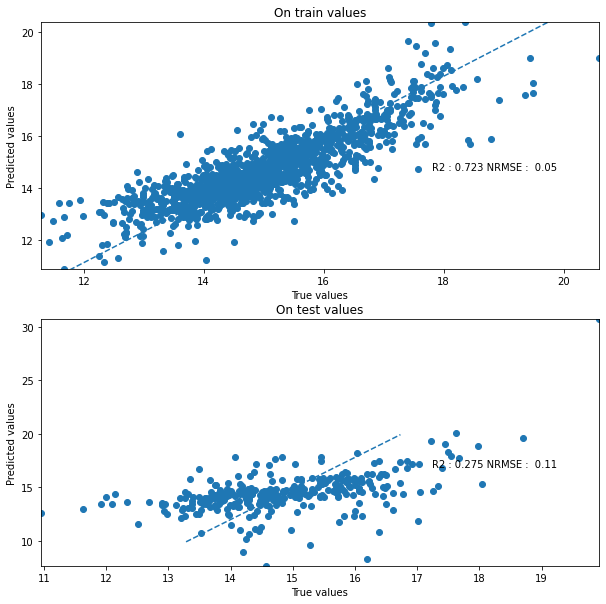

<Figure size 432x288 with 0 Axes>

In [44]:
true_pred_plot(ytrain, model2.predict(xtrain), ytest, model2.predict(xtest))

In [48]:
#now with a multi layer network

model3 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="selu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(383, activation="selu", name="layer2a"),
        layers.Dense(287, activation="selu", name="layer2"),
        layers.Dense(82, activation="selu", name="layer3"),
        layers.Dense(20, activation="selu", name="layer4"),
        layers.Dense(4, activation = "selu", name = "layer5"),
        layers.Dense(1, activation = 'linear', name="layer6"),
    ]
)

model3.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model3.summary()

history3 = model3.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 573)               328902    
                                                                 
 layer2a (Dense)             (None, 383)               219842    
                                                                 
 layer2 (Dense)              (None, 287)               110208    
                                                                 
 layer3 (Dense)              (None, 82)                23616     
                                                                 
 layer4 (Dense)              (None, 20)                1660      
                                                                 
 layer5 (Dense)              (None, 4)                 84        
                                                                 
 layer6 (Dense)              (None, 1)                

11/11 [==============================] - 0s 2ms/step


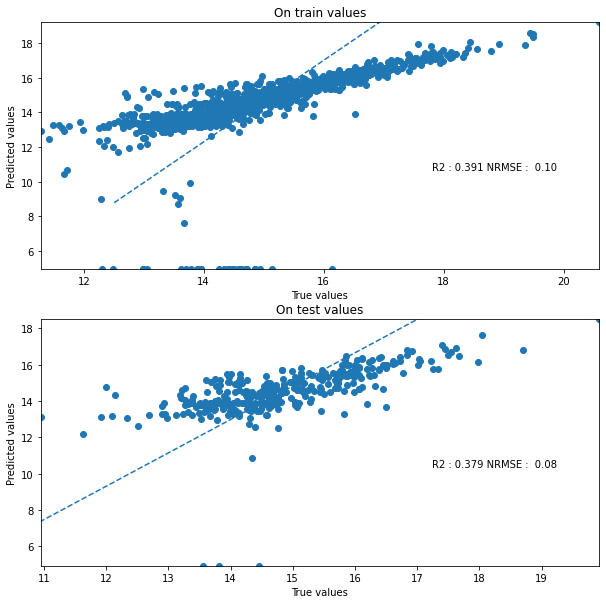

<Figure size 432x288 with 0 Axes>

In [49]:
true_pred_plot(ytrain, model3.predict(xtrain), ytest, model3.predict(xtest))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   20.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


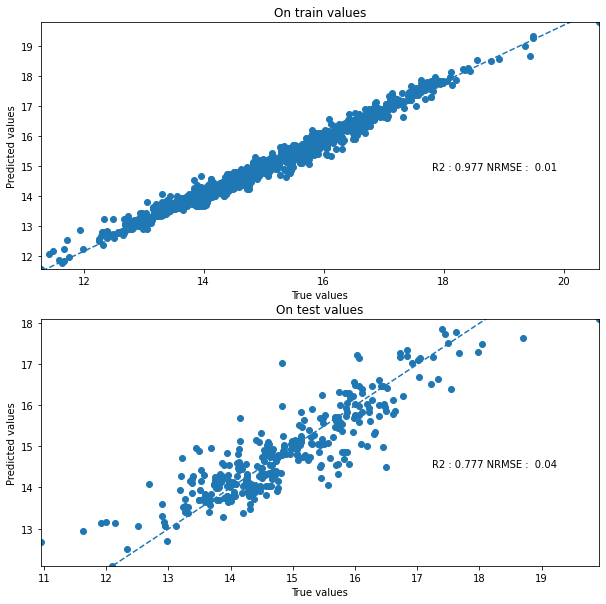

<Figure size 432x288 with 0 Axes>

In [50]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=500, verbose = 1)

model = rfr.fit(xtrain,ytrain)

true_pred_plot(ytrain, model.predict(xtrain), ytest, model.predict(xtest))